<a href="https://colab.research.google.com/github/nkang917/credit-loss-forecasting/blob/main/Lending_Club_Credit_Loss_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: Setup Google Drive Environment & Import Data

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# read the original dataset
accepted = drive.CreateFile({'id':'18-57hbXD29nPolm1akDlQ2H1fC7Gh3tf'}) # replace the id with id of file you want to access
# accepted_100k = drive.CreateFile({'id':'1nn9fSE97dfFk1OPegWDM0UaUJm5nf44B'}) # replace the id with id of file you want to access

accepted.GetContentFile('accepted_2007_to_2018Q4.csv')
# accepted_100k.GetContentFile('accepted_100k.csv')


In [ ]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv')
# df = pd.read_csv('accepted_100k.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_100k = df.sample(100000)

In [ ]:
df_100k.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
660519,83335281,NaN,6600.000,6600.000,6600.000,36 months,11.490,217.620,B,B5,Banker,4 years,MORTGAGE,30000.000,Verified,Jun-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=83335281,NaN,debt_consolidation,Debt consolidation,454xx,OH,17.600,0.000,Mar-2006,660.000,664.000,1.000,NaN,NaN,9.000,0.000,10018.000,77.700,13.000,w,0.000,0.000,6919.200,6919.200,6600.000,319.200,0.000,0.000,0.000,Nov-2016,5852.930,NaN,Feb-2019,704.000,700.000,0.000,NaN,1.000,Individual,NaN,NaN,NaN,0.000,839.000,89582.000,0.000,1.000,0.000,1.000,24.000,3567.000,59.000,0.000,2.000,1331.000,72.000,12900.000,0.000,3.000,1.000,3.000,9954.000,428.000,88.400,0.000,0.000,52.000,123.000,21.000,21.000,1.000,21.000,NaN,3.000,NaN,0.000,3.000,6.000,3.000,5.000,2.000,7.000,10.000,6.000,9.000,0.000,0.000,0.000,0.000,100.000,100.000,0.000,0.000,101792.000,13585.000,3700.000,6000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1376000,144762798,NaN,20000.000,20000.000,20000.000,60 months,16.140,487.860,C,C4,CNA,3 years,MORTGAGE,46000.000,Source Verified,Dec-2018,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=144762798,NaN,debt_consolidation,Debt consolidation,283xx,NC,22.360,0.000,Apr-2009,690.000,694.000,0.000,NaN,NaN,51.000,0.000,3398.000,9.400,82.000,w,19334.550,19334.550,1445.650,1445.650,665.450,780.200,0.000,0.000,0.000,Mar-2019,487.860,Apr-2019,Mar-2019,694.000,690.000,0.000,NaN,1.000,Individual,NaN,NaN,NaN,0.000,2424.000,202455.000,1.000,35.000,3.0

In [ ]:
df_100k.loc[(df_100k['loan_amnt'] >= 5000) & (df_100k['loan_amnt'] <= 6000)].sample(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1198595,26179516,NaN,5000.000,5000.000,5000.000,36 months,12.490,167.250,B,B5,food server,10+ years,MORTGAGE,41000.000,Not Verified,Sep-2014,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=26179516,NaN,debt_consolidation,Debt consolidation,891xx,NV,12.030,0.000,Aug-1998,680.000,684.000,0.000,35.000,NaN,8.000,0.000,5216.000,72.400,20.000,w,0.000,0.000,5396.090,5396.090,5000.000,396.090,0.000,0.000,0.000,May-2015,4225.340,NaN,Feb-2019,609.000,605.000,0.000,35.000,1.000,Individual,NaN,NaN,NaN,0.000,0.000,219444.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7200.000,NaN,NaN,NaN,3.000,31349.000,1063.000,65.700,0.000,0.000,9.000,192.000,9.000,9.000,7.000,9.000,NaN,9.000,NaN,2.000,2.000,4.000,3.000,10.000,1.000,5.000,12.000,4.000,7.000,0.000,0.000,0.000,2.000,90.000,33.300,0.000,0.000,221981.000,11801.000,3100.000,8781.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1715686,97560355,NaN,6000.000,6000.000,6000.000,36 months,15.990,210.920,C,C5,Systems Analyst,2 years,RENT,77000.000,Source Verified,Feb-2017,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=97560355,NaN,debt_consolidation,Debt consolidation,920xx,CA,6.480,0.000,Nov-2009,685.000,689.000,0.000,75.000,NaN,7.000,0.000,5782.000,37.500,8.000,w,2144.550,2144.550,5274.290,5274.290,3855.450,1418.840,0.000,0.000,0.000,Mar-2019,210.920,Apr-2019,Mar-2019,619.000,615.000,0.000,75.000,1.000,Individual,NaN,NaN,NaN,0.000,0.000,20269.000,0.000,1.000,0.000,1.000,19.000,14487.0

#Part 1: Data Exploration

In [ ]:
!pip install lifelines

     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 55 kB 2.2 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=a95f670858ca8969fb4c73fae852fa8739e595c4054287580a3df68868265e99
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


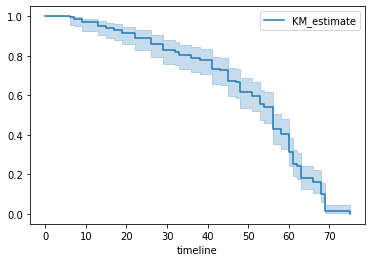

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.datasets import load_waltons

km = load_waltons()
T = km['T']
E = km['E']

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
kmf.plot()

In [ ]:
km.head()

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137


In [ ]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter
rossi = load_rossi()
cph = CoxPHFitter()

In [ ]:
rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [ ]:
cph.fit(rossi, duration_col='week', event_col='arrest')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2022-03-02 20:26:26 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.75            -0.00                 0.47                 1.00
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.37       0.31            -0.29             0.92                 0.75                 2.50
wexp       -0.15       0.86       0.21            -0.57             0.27                 0.57                 1.30
mar        -0.43       0.65       0.38            -1.18             0.31                 0.31                 1.37
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.10       0.03             0.04             0.15                 1.04                 1.16

              z      p   -log2(p)
covariate                        
fin       -1.98   0.05       4.40
age       -2.61   0.01       6.79
race       1.02   0.31       1.70
wexp      -0.71   0.48       1.06
mar       -1.14   0.26       1.97
paro      -0.43   0.66       0.59
prio       3.19 <0.005       9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

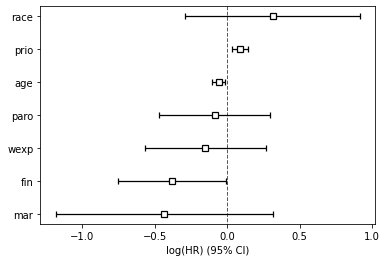

In [ ]:
cph.plot()

In [ ]:
df.loc[df['total_rec_late_fee'] != 0].sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
265306,50557342,NaN,2400.000,2400.000,2400.000,36 months,11.530,79.180,B,B5,clinical director,< 1 year,MORTGAGE,86000.000,Not Verified,Jun-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=50557342,NaN,debt_consolidation,Debt consolidation,806xx,CO,23.460,0.000,Sep-1996,660.000,664.000,1.000,39.000,68.000,13.000,1.000,6801.000,56.200,49.000,f,0.000,0.000,2689.270,2689.270,2400.000,259.270,30.000,0.000,0.000,Oct-2016,27.200,NaN,Mar-2019,734.000,730.000,0.000,39.000,1.000,Individual,NaN,NaN,NaN,0.000,0.000,217648.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12100.000,NaN,NaN,NaN,8.000,16742.000,729.000,86.200,0.000,0.000,224.000,205.000,6.000,6.000,6.000,6.000,79.000,1.000,79.000,2.000,3.000,7.000,3.000,10.000,22.000,7.000,21.000,7.000,13.000,0.000,0.000,0.000,4.000,90.200,66.700,1.000,0.000,238686.000,50954.000,5300.000,54756.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1534916,133378190,NaN,5500.000,5500.000,5500.000,36 months,14.520,189.370,C,C3,Detailer,1 year,RENT,30000.000,Source Verified,May-2018,Late (31-120 days),n,https://lendingclub.com/browse/loanDetail.action?loan_id=133378190,NaN,debt_consolidation,Debt consolidation,923xx,CA,16.640,0.000,Feb-2012,725.000,729.000,0.000,NaN,NaN,4.000,0.000,3182.000,56.800,5.000,w,4415.620,4415.620,1653.460,1653.460,1084.380,554.080,15.000,0.000,0.000,Mar-2019,260.000,Apr-2019,Mar-2019,704.000,700.000,0.000,NaN,1.000,Individual,NaN,NaN,NaN,0.000,0.000,16668.000,0.000,1.000,0.000,1.0

In [ ]:
df.sample(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1750883,94283183,NaN,19775.000,19775.000,19775.000,36 months,23.990,775.730,E,E2,Teacher,10+ years,RENT,60000.000,Verified,Jan-2017,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=94283183,NaN,debt_consolidation,Debt consolidation,660xx,KS,26.140,0.000,Mar-2009,670.000,674.000,1.000,NaN,104.000,10.000,1.000,8466.000,71.100,15.000,w,6968.190,6968.190,20205.950,20205.950,12806.810,7399.140,0.000,0.000,0.000,Mar-2019,775.730,Apr-2019,Mar-2019,639.000,635.000,0.000,NaN,1.000,Individual,NaN,NaN,NaN,0.000,0.000,85295.000,2.000,5.000,2.000,5.000,4.000,76829.000,94.000,0.000,0.000,2399.000,91.000,11900.000,1.000,0.000,7.000,5.000,8530.000,101.000,96.000,0.000,0.000,93.000,90.000,31.000,4.000,0.000,65.000,NaN,5.000,NaN,0.000,1.000,5.000,1.000,1.000,8.000,5.000,7.000,5.000,10.000,0.000,0.000,0.000,2.000,100.000,100.000,1.000,0.000,93830.000,85295.000,2500.000,81930.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
764763,140383240,NaN,10000.000,10000.000,10000.000,36 months,6.110,304.720,A,A1,OPERATOR,10+ years,RENT,52000.000,Not Verified,Sep-2018,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=140383240,NaN,major_purchase,Major purchase,402xx,KY,16.130,0.000,May-2008,730.000,734.000,0.000,24.000,NaN,11.000,0.000,8354.000,33.700,22.000,f,8457.660,8457.660,1821.530,1821.530,1542.340,279.190,0.000,0.000,0.000,Mar-2019,304.720,Apr-2019,Mar-2019,724.000,720.000,0.000,NaN,1.000,Individual,NaN,NaN,NaN,0.000,0.000,21689.000,0.000,2.000,0

In [ ]:
df.info(verbose=True, null_counts=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 151 columns):
 #    Column                                      Non-Null Count    Dtype  
---   ------                                      --------------    -----  
 0    id                                          2260701 non-null  object 
 1    member_id                                   0 non-null        float64
 2    loan_amnt                                   2260668 non-null  float64
 3    funded_amnt                                 2260668 non-null  float64
 4    funded_amnt_inv                             2260668 non-null  float64
 5    term                                        2260668 non-null  object 
 6    int_rate                                    2260668 non-null  float64
 7    installment                                 2260668 non-null  float64
 8    grade                                       2260668 non-null  object 
 9    sub_grade                                   

# Part 2: Feature Space
Reducing feature space can be done before splitting the data, because it will remove the whole columns. It won't cause any info leak.

This part includes:

*   Dropping columns with unique values
*   Dropping columns that give duplicate infomation

But before that, let's define the target feature first:

In [ ]:
df['loan_status'].value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

Keep only 'Fully Paid' and 'Charged Off':


In [ ]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [ ]:
# status counts as percentage
df['loan_status'].value_counts(normalize=True)

Fully Paid    0.800
Charged Off   0.200
Name: loan_status, dtype: float64

**Dropping columns with unique values**

In [ ]:
df.nunique(dropna=False).sort_values()

next_pymnt_d                                        1
member_id                                           1
out_prncp                                           1
out_prncp_inv                                       1
pymnt_plan                                          1
hardship_flag                                       1
policy_code                                         1
deferral_term                                       2
loan_status                                         2
hardship_type                                       2
initial_list_status                                 2
application_type                                    2
term                                                2
disbursement_method                                 2
debt_settlement_flag                                2
hardship_length                                     2
hardship_status                                     3
verification_status                                 3
settlement_status           

In [ ]:
unique_num = df.nunique(dropna=False)
unique_cols = unique_num[unique_num == 1].index
unique_cols

Index(['member_id', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'next_pymnt_d',
       'policy_code', 'hardship_flag'],
      dtype='object')

In [ ]:
df = df.drop(columns=unique_cols)

Feature `id` and `url` have a unique value for each row and should also be removed, otherwise the model will overfit.

In [ ]:
df = df.drop(columns=['id', 'url'])

(Easy drop try: Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns.)

In [ ]:
missing_fractions = df.isnull().mean().sort_values(ascending=False)
missing_fractions

orig_projected_additional_accrued_interest   0.997
hardship_payoff_balance_amount               0.996
hardship_amount                              0.996
hardship_start_date                          0.996
hardship_end_date                            0.996
payment_plan_start_date                      0.996
hardship_reason                              0.996
hardship_length                              0.996
hardship_dpd                                 0.996
hardship_loan_status                         0.996
deferral_term                                0.996
hardship_status                              0.996
hardship_type                                0.996
hardship_last_payment_amount                 0.996
sec_app_mths_since_last_major_derog          0.995
sec_app_revol_util                           0.986
revol_bal_joint                              0.986
sec_app_collections_12_mths_ex_med           0.986
sec_app_mort_acc                             0.986
sec_app_open_acc               

In [ ]:
drop_list = sorted(missing_fractions[missing_fractions > 0.3].index)
drop_list

['all_util',
 'annual_inc_joint',
 'debt_settlement_flag_date',
 'deferral_term',
 'desc',
 'dti_joint',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'il_util',
 'inq_fi',
 'inq_last_12m',
 'max_bal_bc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'open_rv_12m',
 'open_rv_24m',
 'orig_projected_additional_accrued_interest',
 'payment_plan_start_date',
 'revol_bal_joint',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_earliest_cr_line',
 'sec_app_fico_range_high',
 'sec_app_fico_range_low',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_mths

In [ ]:
df = df.drop(columns=drop_list)
df.shape

(1345310, 86)

Select features using five C's of Credit framework

In [ ]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'verification_status', 'zip_code']
drop_list_2 = [col for col in df.columns if col not in keep_list]

In [ ]:
drop_list_2

['funded_amnt',
 'funded_amnt_inv',
 'issue_d',
 'delinq_2yrs',
 'inq_last_6mths',
 'total_pymnt_inv',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tax_liens',
 'tot_hi_cred_lim',
 'total_bal_ex_mo

In [ ]:
df = df.drop(columns=drop_list_2)

In [ ]:
df.shape

(1345310, 32)

Todo: (Features regarding hardship plan)

We found that features regarding hardship plan have same number of null values, which means these records with null values represent borrowers without a hardship plan.

**Dropping columns that give duplicate infomation**

### `fico_range_low` & `fico_range_high`

In [ ]:
df[['fico_range_low','fico_range_high']].describe()

,fico_range_low,fico_range_high
count,1345310.000,1345310.000
mean,696.185,700.185
std,31.853,31.853
min,625.000,629.000
25%,670.000,674.000
50%,690.000,694.000
75%,710.000,714.000
max,845.000,850.000


In [ ]:
df[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.000,1.000
fico_range_high,1.000,1.000


Because these two columns Pearson correlation is `1`, we'll only take the average of two and call it fico_score and drop the original two.

In [ ]:
df['fico_score'] = (df['fico_range_low'] + df['fico_range_high']) // 2

In [ ]:
df['fico_score'].describe()

count   1345310.000
mean        698.185
std          31.853
min         627.000
25%         672.000
50%         692.000
75%         712.000
max         847.000
Name: fico_score, dtype: float64

In [ ]:
df = df.drop(columns=['fico_range_low', 'fico_range_high'])

###`purpose` & `title`

In [ ]:
df['purpose'].value_counts().sort_values(ascending=False).head(10)

debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
medical                15554
small_business         15416
car                    14585
moving                  9480
vacation                9065
Name: purpose, dtype: int64

In [ ]:
df['purpose'].describe()

count                1345310
unique                    14
top       debt_consolidation
freq                  780321
Name: purpose, dtype: object

In [ ]:
df['title'].value_counts().sort_values(ascending=False).head(10)

Debt consolidation         660960
Credit card refinancing    249910
Home improvement            75073
Other                       66778
Major purchase              24045
Debt Consolidation          15695
Medical expenses            13576
Business                    11750
Car financing               11220
Vacation                     8046
Name: title, dtype: int64

In [ ]:
df['title'].describe()

count                1328651
unique                 61682
top       Debt consolidation
freq                  660960
Name: title, dtype: object

`title` has higher cardinality to `purpose`, and `purpose` appears to already contain the infomation `title` provide. So we drop `title`.

In [ ]:
df = df.drop(columns='title')

### `grade` & `sub_grade`

In [ ]:
df['grade'].value_counts(dropna=False).sort_index()

A    235090
B    392741
C    381686
D    200953
E     93650
F     32058
G      9132
Name: grade, dtype: int64

In [ ]:
df['sub_grade'].value_counts(dropna=False).sort_index()

A1    43678
A2    37178
A3    37996
A4    52235
A5    64003
B1    71153
B2    74024
B3    81827
B4    83199
B5    82538
C1    85494
C2    79213
C3    74998
C4    74421
C5    67560
D1    51321
D2    44848
D3    39317
D4    35566
D5    29901
E1    23749
E2    21377
E3    18387
E4    15720
E5    14417
F1     9970
F2     7198
F3     6088
F4     4859
F5     3943
G1     2997
G2     2131
G3     1614
G4     1280
G5     1110
Name: sub_grade, dtype: int64

Since `sub_grade` contain the information that `grade` has, we drop `grade`.

In [ ]:
df = df.drop(columns='grade')

### `emp_title`

In [ ]:
df['emp_title'].value_counts(dropna=False).sort_values(ascending=False).head(25)

NaN                         85785
Teacher                     21268
Manager                     19470
Owner                       10302
Registered Nurse             8774
RN                           8522
Supervisor                   8289
Driver                       7558
Sales                        7487
Project Manager              6381
Office Manager               5526
General Manager              5191
Director                     5032
owner                        4585
manager                      4511
Engineer                     4294
President                    4162
teacher                      4094
Vice President               3539
driver                       3514
Operations Manager           3457
Accountant                   3287
Administrative Assistant     3096
Sales Manager                3072
Attorney                     3061
Name: emp_title, dtype: int64

In [ ]:
df['emp_title'].nunique()

378353

There are too many different job titles for this feature to be useful, so let's drop it.

In [ ]:
df = df.drop(columns='emp_title')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 28 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1345310 non-null  float64
 1   term                  1345310 non-null  object 
 2   int_rate              1345310 non-null  float64
 3   installment           1345310 non-null  float64
 4   sub_grade             1345310 non-null  object 
 5   emp_length            1266799 non-null  object 
 6   home_ownership        1345310 non-null  object 
 7   annual_inc            1345310 non-null  float64
 8   verification_status   1345310 non-null  object 
 9   loan_status           1345310 non-null  object 
 10  purpose               1345310 non-null  object 
 11  zip_code              1345309 non-null  object 
 12  addr_state            1345310 non-null  object 
 13  dti                   1344936 non-null  float64
 14  earliest_cr_line      1345310 non-

# Part 3: Split the data

Split the data before data preprocessing

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['loan_status'])
print('Training data has ' + str(train.shape[0]) + ' observations with ' + str(train.shape[1]) + ' features.')
print('Testing data has ' + str(test.shape[0]) + ' observations with ' + str(test.shape[1]) + ' feature.')

Training data has 1076248 observations with 28 features.
Testing data has 269062 observations with 28 feature.


# Part 4: Data Preprocessing

## Part 4.1: Missing Data

Now take care of **numerical** features with missing data.

In [ ]:
# check all the numerical feature's null value
train.select_dtypes('float64').isnull().sum().sort_values(ascending=False)

mort_acc                37936
revol_util                672
pub_rec_bankruptcies      552
dti                       303
loan_amnt                   0
int_rate                    0
installment                 0
annual_inc                  0
open_acc                    0
pub_rec                     0
revol_bal                   0
total_acc                   0
total_pymnt                 0
total_rec_prncp             0
total_rec_int               0
fico_score                  0
dtype: int64

In [ ]:
# def a function to make box plot
def box_plot(col_name):
  sns.boxplot(x=col_name, y='loan_status', data=train)

### `mort_acc`

Data Dictionary: Number of mortgage accounts.

In [ ]:
train['mort_acc'].value_counts(dropna=False).sort_index()

0.000     418353
1.000     181174
2.000     151317
3.000     111689
4.000      75957
5.000      46115
6.000      25977
7.000      13450
8.000       6752
9.000       3463
10.000      1749
11.000       939
12.000       514
13.000       282
14.000       195
15.000       108
16.000        78
17.000        44
18.000        37
19.000        24
20.000        20
21.000        12
22.000        12
23.000         5
24.000        13
25.000         7
26.000         4
27.000         6
28.000         2
29.000         4
30.000         1
31.000         1
32.000         1
34.000         3
35.000         1
37.000         1
47.000         1
51.000         1
NaN        37936
Name: mort_acc, dtype: int64

In [ ]:
train['mort_acc'].describe()

count   1038312.000
mean          1.672
std           1.999
min           0.000
25%           0.000
50%           1.000
75%           3.000
max          51.000
Name: mort_acc, dtype: float64

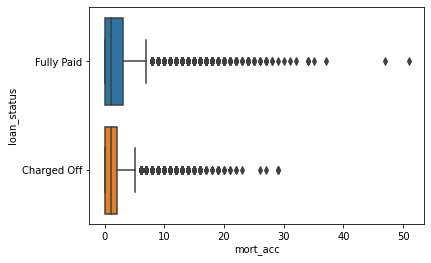

In [ ]:
box_plot('mort_acc')

Fill NaN with mean

In [ ]:
train['mort_acc'] = train['mort_acc'].fillna(train['mort_acc'].mean())
test['mort_acc'] = test['mort_acc'].fillna(test['mort_acc'].mean())

### `revol_util`

Data Dictionary: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [ ]:
train['revol_util'].describe()

count   1075576.000
mean         51.806
std          24.517
min           0.000
25%          33.500
50%          52.200
75%          70.700
max         892.300
Name: revol_util, dtype: float64

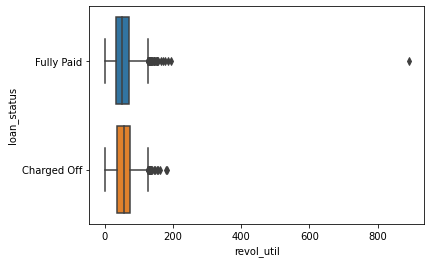

In [ ]:
box_plot('revol_util')

There is a outlier for in training dataset. Don't know why this happens. Just fill NaN with mean.

In [ ]:
train['revol_util'] = train['revol_util'].fillna(train['revol_util'].mean())
test['revol_util'] = test['revol_util'].fillna(test['revol_util'].mean())

### `pub_rec_bankruptcies`

Data Dictionary: Number of public record bankruptcies

In [ ]:
train['pub_rec_bankruptcies'].value_counts(dropna=False).sort_index()

0.000     941468
1.000     126207
2.000       6256
3.000       1270
4.000        322
5.000        114
6.000         38
7.000         10
8.000          7
9.000          3
12.000         1
NaN          552
Name: pub_rec_bankruptcies, dtype: int64

Fill NaN with mean.

In [ ]:
train['pub_rec_bankruptcies'] = train['pub_rec_bankruptcies'].fillna(train['pub_rec_bankruptcies'].mean())
test['pub_rec_bankruptcies'] = test['pub_rec_bankruptcies'].fillna(test['pub_rec_bankruptcies'].mean())

### `dti`

Data Dictionary: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

In [ ]:
train['dti'].describe()

count   1075945.000
mean         18.276
std          11.035
min          -1.000
25%          11.790
50%          17.620
75%          24.050
max         999.000
Name: dti, dtype: float64

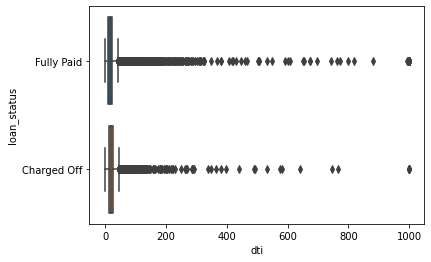

In [ ]:
box_plot('dti')

Fill null with mean.

In [ ]:
train['dti'] = train['dti'].fillna(train['dti'].mean())
test['dti'] = test['dti'].fillna(test['dti'].mean())

Now take care of **categorical** features with missing data.

In [ ]:
# check all the categorical feature's null value
df.select_dtypes('object').isnull().sum().sort_values(ascending=False)

emp_length             78511
zip_code                   1
term                       0
sub_grade                  0
home_ownership             0
verification_status        0
loan_status                0
purpose                    0
addr_state                 0
earliest_cr_line           0
initial_list_status        0
application_type           0
dtype: int64

### `emp_length`

Data Dictionary: Employment length in years.

In [ ]:
train['emp_length'].value_counts(dropna=False).sort_index()

1 year        70637
10+ years    354019
2 years       97274
3 years       86036
4 years       64396
5 years       67305
6 years       50122
7 years       47768
8 years       48588
9 years       40725
< 1 year      86408
NaN           62970
Name: emp_length, dtype: int64

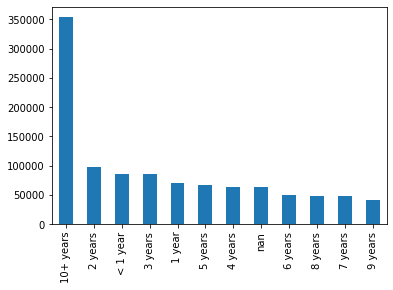

In [ ]:
train['emp_length'].value_counts(dropna=False).plot.bar()

Convert `emp_length` to floats and fill NaN with mean.

In [ ]:
train['emp_length'].replace('10+ years', '10 years', inplace=True)
train['emp_length'].replace('< 1 year', '0 year', inplace=True)

test['emp_length'].replace('10+ years', '10 years', inplace=True)
test['emp_length'].replace('< 1 year', '0 year', inplace=True)

In [ ]:
def emp_length_to_int(year):
  if pd.isnull(year):
    return year
  else:
    return np.int(year.split()[0])

In [ ]:
train['emp_length'] = train['emp_length'].apply(emp_length_to_int)
test['emp_length'] = test['emp_length'].apply(emp_length_to_int)

In [ ]:
train['emp_length'] = train['emp_length'].fillna(train['emp_length'].mean())
test['emp_length'] = test['emp_length'].fillna(test['emp_length'].mean())

### `zip_code`

Data Dictionary: The first 3 numbers of the zip code provided by the borrower in the loan application.

In [ ]:
train['zip_code'].nunique()

935

In [ ]:
train.loc[df['zip_code'].isnull()]

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_pymnt,total_rec_prncp,total_rec_int,application_type,mort_acc,pub_rec_bankruptcies,fico_score
1736050,5600.000,36 months,15.990,196.860,C5,10.000,MORTGAGE,40000.000,Verified,Fully Paid,debt_consolidation,NaN,AL,22.860,Jul-2005,8.000,1.000,7129.000,68.500,18.000,f,6895.874,5600.000,1295.870,Individual,4.000,1.000,672.000


There is only one borrower whose zipcode is NaN in training and testing. Drop it.

In [ ]:
train = train.dropna(subset=['zip_code'])

In [ ]:
# Since there are too many zip code to be transform to dummy value, drop it for now
train.drop(columns='zip_code', inplace=True)
test.drop(columns='zip_code', inplace=True)

In [ ]:
train.shape

(1076247, 27)

In [ ]:
test.shape

(269062, 27)

In [ ]:
train.isna().any()

loan_amnt               False
term                    False
int_rate                False
installment             False
sub_grade               False
emp_length              False
home_ownership          False
annual_inc              False
verification_status     False
loan_status             False
purpose                 False
addr_state              False
dti                     False
earliest_cr_line        False
open_acc                False
pub_rec                 False
revol_bal               False
revol_util              False
total_acc               False
initial_list_status     False
total_pymnt             False
total_rec_prncp         False
total_rec_int           False
application_type        False
mort_acc                False
pub_rec_bankruptcies    False
fico_score              False
dtype: bool

In [ ]:
test.isna().any()

loan_amnt               False
term                    False
int_rate                False
installment             False
sub_grade               False
emp_length              False
home_ownership          False
annual_inc              False
verification_status     False
loan_status             False
purpose                 False
addr_state              False
dti                     False
earliest_cr_line        False
open_acc                False
pub_rec                 False
revol_bal               False
revol_util              False
total_acc               False
initial_list_status     False
total_pymnt             False
total_rec_prncp         False
total_rec_int           False
application_type        False
mort_acc                False
pub_rec_bankruptcies    False
fico_score              False
dtype: bool

## Part 4.2: Catogorical features

In [ ]:
train.dtypes.sort_values()

loan_amnt               float64
mort_acc                float64
total_rec_int           float64
total_rec_prncp         float64
total_pymnt             float64
total_acc               float64
revol_util              float64
revol_bal               float64
pub_rec                 float64
open_acc                float64
pub_rec_bankruptcies    float64
dti                     float64
fico_score              float64
annual_inc              float64
emp_length              float64
installment             float64
int_rate                float64
purpose                  object
loan_status              object
verification_status      object
home_ownership           object
initial_list_status      object
sub_grade                object
application_type         object
term                     object
addr_state               object
earliest_cr_line         object
dtype: object

### `earliest_cr_line`

Data Dictionary: The month the borrower's earliest reported credit line was opened

In [ ]:
train['earliest_cr_line'].sample(5)

1179411    Jul-2008
1657935    Oct-1998
110879     Oct-1989
895377     Apr-2005
1205052    Jul-2002
Name: earliest_cr_line, dtype: object

In [ ]:
df['earliest_cr_line'].nunique()

739

Let's just retain the year for simplicity:

In [ ]:
train['cr_line_year'] = train['earliest_cr_line'].apply(lambda s: int(s[-4:]))
test['cr_line_year'] = test['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [ ]:
train['cr_line_year'].describe([.1, .2, .3, .4, .5, .6, .7, .8, .9])

count   1076247.000
mean       1998.691
std           7.599
min        1944.000
10%        1988.000
20%        1993.000
30%        1996.000
40%        1998.000
50%        2000.000
60%        2002.000
70%        2003.000
80%        2005.000
90%        2007.000
max        2015.000
Name: cr_line_year, dtype: float64

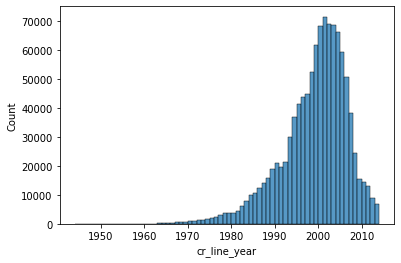

In [ ]:
sns.histplot(train['cr_line_year'], bins=range(1944, 2015, 1))

In [ ]:
bin_year = train['cr_line_year'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9]).values.astype(int)
bin_year

array([1988, 1993, 1996, 1998, 2000, 2002, 2003, 2005, 2007])

In [ ]:
train['cr_line_year'].dtypes

dtype('int64')

In [ ]:
all_bin_year = [train['cr_line_year'].min()]
all_bin_year.extend(bin_year)
all_bin_year.append(train['cr_line_year'].max())
all_bin_year

[1944, 1988, 1993, 1996, 1998, 2000, 2002, 2003, 2005, 2007, 2015]

In [ ]:
# make year range labels
year_range = []
for i in range(len(all_bin_year) - 1):
  year = '{}-{}'.format(all_bin_year[i], all_bin_year[i+1])
  year_range.append(year)
year_range

['1944-1988',
 '1988-1993',
 '1993-1996',
 '1996-1998',
 '1998-2000',
 '2000-2002',
 '2002-2003',
 '2003-2005',
 '2005-2007',
 '2007-2015']

In [ ]:
train['cr_line_year_bin'] = pd.cut(train['cr_line_year'], all_bin_year, labels=year_range)
test['cr_line_year_bin'] = pd.cut(test['cr_line_year'], all_bin_year, labels=year_range)
train.drop(columns=['earliest_cr_line', 'cr_line_year'], inplace=True)
test.drop(columns=['earliest_cr_line', 'cr_line_year'], inplace=True)
train.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_pymnt,total_rec_prncp,total_rec_int,application_type,mort_acc,pub_rec_bankruptcies,fico_score,cr_line_year_bin
1959284,36750.000,60 months,22.390,1023.170,E1,9.000,MORTGAGE,84000.000,Verified,Fully Paid,debt_consolidation,IN,25.130,13.000,5.000,19109.000,53.700,18.000,w,43695.322,36750.000,6945.320,Joint App,1.000,0.000,712.000,2000-2002
388387,10000.000,36 months,11.440,329.480,B4,5.000,RENT,50000.000,Source Verified,Fully Paid,credit_card,FL,6.700,5.000,1.000,6716.000,79.000,8.000,f,11827.156,10000.000,1827.160,Individual,0.000,1.000,667.000,2003-2005
700527,4200.000,36 months,9.750,135.030,B3,5.969,MORTGAGE,49200.000,Source Verified,Fully Paid,home_improvement,AL,3.240,3.000,0.000,5504.000,54.500,6.000,f,4675.796,4200.000,475.800,Individual,3.000,0.000,782.000,1998-2000
2138115,6000.000,36 months,14.080,205.300,C3,5.969,OWN,18720.000,Source Verified,Fully Paid,debt_consolidation,MO,9.100,4.000,1.000,4787.000,68.400,6.000,w,6843.830,6000.000,843.830,Individual,1.000,1.000,662.000,1998-2000
203873,7650.000,36 months,14.650,263.890,C5,1.000,OWN,40000.000,Not Verified,Charged Off,home_improvement,KS,14.400,7.000,1.000,1849.000,24.000,28.000,f,3932.590,1801.740,830.930,Individual,6.000,1.000,672.000,1988-1993


### `home_ownership`

In [ ]:
train['home_ownership'].value_counts()

MORTGAGE    532817
RENT        427235
OWN         115803
ANY            230
OTHER          123
NONE            39
Name: home_ownership, dtype: int64

Replace the values `ANY` and `NONE` with `OTHER`:

In [ ]:
train['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)
test['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

### One Hot Encoding

Take care of target feature:

In [ ]:
train['loan_status'] = (train['loan_status'] == 'Charged Off').astype(int)
test['loan_status'] = (test['loan_status'] == 'Charged Off').astype(int)

In [ ]:
train['loan_status'].value_counts()

0    861400
1    214847
Name: loan_status, dtype: int64

In [ ]:
test['loan_status'].value_counts()

0    215350
1     53712
Name: loan_status, dtype: int64

Occasionaly, training and testing contain different feature cardinality (e.g. State). So we can't use get_dummy to do the one hot encoding. We use OneHotEncoder here:


In [ ]:
train.dtypes

loan_amnt                float64
term                      object
int_rate                 float64
installment              float64
sub_grade                 object
emp_length               float64
home_ownership            object
annual_inc               float64
verification_status       object
loan_status                int64
purpose                   object
addr_state                object
dti                      float64
open_acc                 float64
pub_rec                  float64
revol_bal                float64
revol_util               float64
total_acc                float64
initial_list_status       object
total_pymnt              float64
total_rec_prncp          float64
total_rec_int            float64
application_type          object
mort_acc                 float64
pub_rec_bankruptcies     float64
fico_score               float64
cr_line_year_bin        category
dtype: object

In [ ]:
cat_cols = train.columns[(train.dtypes == 'O') | (train.dtypes == 'category')]

In [ ]:
cat_cols

Index(['term', 'sub_grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state', 'initial_list_status', 'application_type',
       'cr_line_year_bin'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, encoder, cols):
  transformed = pd.DataFrame(encoder.transform(df[cols]).toarray(), columns=encoder.get_feature_names(cols))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(cat_cols, axis=1)

### Undersampling

In [ ]:
default_train_undersampling = train.loc[train['loan_status'] == 1]

In [ ]:
non_default_train_undersampling = train.loc[train['loan_status'] == 0].sample(n=214847, random_state=42)

In [ ]:
train_undersampling = pd.concat([default_train_undersampling, non_default_train_undersampling])

In [ ]:
X_train_undersampling = train_undersampling.drop(columns='loan_status')
X_test_undersampling = test.drop(columns='loan_status')

y_train_undersampling = train_undersampling['loan_status']
y_test_undersampling = test['loan_status']

In [ ]:
X_train = train.drop(columns='loan_status')
X_test = test.drop(columns='loan_status')

y_train = train['loan_status']
y_test = test['loan_status']

In [ ]:
X_train_undersampling.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_pymnt,total_rec_prncp,total_rec_int,application_type,mort_acc,pub_rec_bankruptcies,fico_score,cr_line_year_bin
203873,7650.000,36 months,14.650,263.890,C5,1.000,OWN,40000.000,Not Verified,home_improvement,KS,14.400,7.000,1.000,1849.000,24.000,28.000,f,3932.590,1801.740,830.930,Individual,6.000,1.000,672.000,1988-1993
1977959,6600.000,36 months,7.990,206.790,A4,4.000,OWN,57500.000,Not Verified,debt_consolidation,MI,24.930,13.000,0.000,8968.000,39.900,30.000,w,4716.760,1873.180,546.580,Individual,1.000,0.000,722.000,2005-2007
56459,18000.000,60 months,9.990,382.360,B3,7.000,MORTGAGE,70000.000,Verified,debt_consolidation,NE,30.650,14.000,0.000,19016.000,46.000,43.000,w,13754.970,9713.210,4041.760,Individual,2.000,0.000,712.000,1988-1993
1234935,18000.000,60 months,16.990,447.250,D3,0.000,MORTGAGE,65000.000,Verified,debt_consolidation,OK,11.800,12.000,0.000,8342.000,63.700,16.000,w,9007.500,3190.340,3518.410,Individual,1.000,0.000,677.000,2007-2015
59430,28000.000,60 months,13.180,639.670,C3,10.000,RENT,95000.000,Source Verified,debt_consolidation,FL,8.510,8.000,0.000,29124.000,67.900,26.000,w,6995.370,3860.900,3134.470,Individual,0.000,0.000,672.000,2003-2005


In [ ]:
enc = OneHotEncoder()
enc.fit(X_train_undersampling[cat_cols])

X_train_undersampling = OneHotEncoding(X_train_undersampling, enc, cat_cols)
X_test_undersampling = OneHotEncoding(X_test_undersampling, enc, cat_cols)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# one hot encoding for original dataset
enc_ori = OneHotEncoder()
enc_ori.fit(X_train[cat_cols])

X_train_ohe = OneHotEncoding(X_train, enc_ori, cat_cols)
X_test_ohe = OneHotEncoding(X_test, enc_ori, cat_cols)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
y_train_undersampling.value_counts()

1    214847
0    214847
Name: loan_status, dtype: int64

In [ ]:
X_train_undersampling.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,mort_acc,pub_rec_bankruptcies,fico_score,term_ 36 months,term_ 60 months,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,cr_line_year_bin_1944-1988,cr_line_year_bin_1988-1993,cr_line_year_bin_1993-1996,cr_line_year_bin_1996-1998,cr_line_year_bin_1998-2000,cr_line_year_bin_2000-2002,cr_line_year_bin_2002-2003,cr_line_year_bin_2003-2005,cr_line_year_bin_2005-2007,cr_line_year_bin_2007-2015,cr_line_year_bin_nan
0,7650.000,14.650,263.890,1.000,40000.000,14.400,7.000,1.000,1849.000,24.000,28.000,3932.590,1801.740,830.930,6.000,1.000,672.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,6600.000,7.990,206.790,4.000,57500.000,24.930,13.000,0.000,8968.000,39.900,30.000,4716.760,1873.180,546.580,1.000,0.000,722.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
2,18000.000,9.990,382.3

### Oversampling

In [ ]:
#@title
# X_train_oversampling = train.drop(columns='loan_status')
# X_test_oversampling = test.drop(columns='loan_status')

# y_train_oversampling = train['loan_status']
# y_test_oversampling = test['loan_status']

In [ ]:
# #@title
# enc = OneHotEncoder()
# enc.fit(X_train_oversampling[cat_cols])

# X_train_oversampling = OneHotEncoding(X_train_oversampling, enc, cat_cols)
# X_test_oversampling = OneHotEncoding(X_test_oversampling, enc, cat_cols)

In [ ]:
# #@title
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=12)
# X_train_sm, y_train_sm = smote.fit_resample(X_train_oversampling, y_train_oversampling)

In [ ]:
#@title
# y_train_sm.value_counts()

## Part 4.3: Data Standardize

We use standard scaling

In [ ]:
num_cols = X_train_undersampling.columns[(X_train_undersampling.dtypes == 'float64') | (X_train_undersampling.dtypes == 'int64')]

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_undersampling[num_cols])
X_train_undersampling[num_cols] = scaler.transform(X_train_undersampling[num_cols])
X_test_undersampling[num_cols] = scaler.transform(X_test_undersampling[num_cols])

In [ ]:
X_train_undersampling.shape

(429694, 141)

In [ ]:
# scaler = StandardScaler()
# scaler.fit(X_train_sm[num_cols])
# X_train_sm[num_cols] = scaler.transform(X_train_sm[num_cols])
# X_test_oversampling[num_cols] = scaler.transform(X_test_oversampling[num_cols])

In [ ]:
X_train_undersampling.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,mort_acc,pub_rec_bankruptcies,fico_score,term_ 36 months,term_ 60 months,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,cr_line_year_bin_1944-1988,cr_line_year_bin_1988-1993,cr_line_year_bin_1993-1996,cr_line_year_bin_1996-1998,cr_line_year_bin_1998-2000,cr_line_year_bin_2000-2002,cr_line_year_bin_2002-2003,cr_line_year_bin_2003-2005,cr_line_year_bin_2005-2007,cr_line_year_bin_2007-2015,cr_line_year_bin_nan
0,-0.821,0.099,-0.703,-1.380,-0.507,-0.414,-0.851,1.250,-0.662,-1.189,0.260,-0.871,-0.892,-0.631,2.328,2.208,-0.769,0.652,-0.652,-0.151,-0.141,-0.145,-0.174,-0.197,-0.212,-0.220,-0.237,-0.244,-0.247,-0.258,-0.252,-0.249,-0.254,4.113,-0.215,-0.203,-0.189,-0.184,-0.169,-0.154,-0.146,-0.138,-0.128,-0.124,-0.103,-0.089,-0.081,-0.074,-0.067,-0.058,-0.049,-0.043,-0.039,-0.036,-0.939,-0.019,2.858,-0.855,1.638,-0.808,-0.707,-0.099,-0.510,-1.209,-0.015,3.896,-0.074,-0.148,-0.109,-0.088,-0.251,-0.026,-0.117,-0.082,-0.039,-0.049,-0.114,-0.090,-0.158,-0.412,-0.143,-0.119,-0.047,-0.053,-0.281,-0.180,-0.071,-0.002,-0.035,-0.196,-0.130,11.166,-0.098,-0.112,-0.152,-0.157,-0.036,-0.164,-0.134,-0.128,-0.074,-0.052,-0.172,-0.035,-0.053,-0.065,-0.196,-0.075,-0.125,-0.305,-0.185,-0.098,-0.105,-0.189,-0.065,-0.105,-0.046,-0.126,-0.298,-0.085,-0.170,-0.042,-0.143,-0.114,-0.058,-0.044,1.190,-1.190,0.145,-0.145,-0.328,3.037,-0.351,-0.311,-0.368,-0.389,-0.263,-0.372,-0.308,-0.302,-0.002
1,-0.941,-1.243,-0.920,-0.540,-0.246,0.541,0.234,-0.367,-0.327,-0.534,0.426,-0.790,-0.883,-0.738,-0.294,-0.366,0.898,0.652,-0.652,-0.151,-0.141,-0.145,5.739,-0.197,-0.212,-0.220,-0.237,-0.244,-0.247,-0.258,-0.252,-0.249,-0.254,-0.243,-0.215,-0.203,-0.189,-0.184,-0.169,-0.154,-0.146,-0.138,-0.128,-0.124,-0.103,-0.089,-0.081,-0.074,-0.067,-0.058,-0.049,-0.043,-0.039,-0.036,-0.939,-0.019,2.858,-0.855,1.638,-0.808,-0.707,-0.099,-0.510,0.827,-0.015,-0.257,-0.074,-0.148,-0.109,-0.088,-0.251,-0.026,-0.117,-0.082,-0.039,-0.049,-0.114,-0.090,-0.158,-0.412,-0.143,-0.119,-0.047,-0.053,-0.281,-0.180,-0.071,-0.002,-0.035,-0.196,-0.130,-0.090,-0.098,-0.112,-0.152,-0.157,-0.036,6.088,-0.134,-0.128,-0.074,-0.052,-0.172,-0.035,-0.053,-0.065,-0.196,-0.075,-0.125,-0.305,-0.185,-0.098,-0.105,-0.189,-0.06

# Part 5: Model Training

The algorithm we will use here:

*   Logistic Regression
*   Random Forest
*   XGBoost



In [ ]:
# helper function for printing out grid search results
def gs_results(gs):
  print('Best score: ' + str(gs.best_score_))
  print('Best parameters: ')
  best_params = gs.best_params_
  for param in best_params.keys():
    print('\t\t' + param + ': ' + str(best_params[param]))

## Part 5.1: Logistic Regression

In [ ]:
clf_lr = LogisticRegression()

In [ ]:
# C = 1/lambda
lr_params = {
    'C':(10, 100),
    'max_iter': [250, 350]
}

In [ ]:
Grid_LR = GridSearchCV(clf_lr, param_grid=lr_params, scoring='recall', verbose=3)
Grid_LR.fit(X_train_undersampling, y_train_undersampling)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5] END ................C=10, max_iter=250;, score=0.989 total time=  30.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END ................C=10, max_iter=250;, score=0.988 total time=  30.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END ................C=10, max_iter=250;, score=0.989 total time=  31.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/5] END ................C=10, max_iter=250;, score=0.989 total time=  31.3s
[CV 5/5] END ................C=10, max_iter=250;, score=0.989 total time=  30.5s
[CV 1/5] END ................C=10, max_iter=350;, score=0.989 total time=  31.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END ................C=10, max_iter=350;, score=0.988 total time=  43.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END ................C=10, max_iter=350;, score=0.989 total time=  43.1s
[CV 4/5] END ................C=10, max_iter=350;, score=0.988 total time=  37.5s
[CV 5/5] END ................C=10, max_iter=350;, score=0.989 total time=  30.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5] END ...............C=100, max_iter=250;, score=0.990 total time=  30.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END ...............C=100, max_iter=250;, score=0.990 total time=  30.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END ...............C=100, max_iter=250;, score=0.990 total time=  30.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/5] END ...............C=100, max_iter=250;, score=0.990 total time=  30.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/5] END ...............C=100, max_iter=250;, score=0.990 total time=  29.8s
[CV 1/5] END ...............C=100, max_iter=350;, score=0.990 total time=  32.8s
[CV 2/5] END ...............C=100, max_iter=350;, score=0.990 total time=  41.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END ...............C=100, max_iter=350;, score=0.990 total time=  42.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/5] END ...............C=100, max_iter=350;, score=0.990 total time=  41.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/5] END ...............C=100, max_iter=350;, score=0.990 total time=  41.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': (10, 100), 'max_iter': [250, 350]},
             scoring='recall', verbose=3)

In [ ]:
gs_results(Grid_LR)

Best score: 0.9899882244584672
Best parameters: 
		C: 100
		max_iter: 350


In [ ]:
# best model
best_lr_model = Grid_LR.best_estimator_

In [ ]:
print(classification_report(y_test_undersampling, best_lr_model.predict(X_test_undersampling)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    215350
           1       0.99      0.99      0.99     53712

    accuracy                           1.00    269062
   macro avg       1.00      0.99      0.99    269062
weighted avg       1.00      1.00      1.00    269062



In [ ]:
from sklearn.metrics import roc_auc_score

lr_auc = roc_auc_score(y_test_undersampling, best_lr_model.predict(X_test_undersampling))
lr_auc

0.9940607222732991

In [ ]:
confusion_matrix(y_test_undersampling, best_lr_model.predict(X_test_undersampling))

array([[214957,    393],
       [   540,  53172]])

## Part 5.2: Random Forest

In [ ]:
clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1)

In [ ]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20]
}

In [ ]:
Grid_RF = GridSearchCV(clf_rf, param_grid=rf_params, scoring='recall', verbose=3)
Grid_RF.fit(X_train_undersampling, y_train_undersampling)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....max_depth=10, n_estimators=50;, score=0.895 total time=  23.1s
[CV 2/5] END .....max_depth=10, n_estimators=50;, score=0.892 total time=  21.2s
[CV 3/5] END .....max_depth=10, n_estimators=50;, score=0.903 total time=  21.1s
[CV 4/5] END .....max_depth=10, n_estimators=50;, score=0.897 total time=  20.9s
[CV 5/5] END .....max_depth=10, n_estimators=50;, score=0.901 total time=  23.1s
[CV 1/5] END ....max_depth=10, n_estimators=100;, score=0.895 total time=  42.1s
[CV 2/5] END ....max_depth=10, n_estimators=100;, score=0.888 total time=  42.0s
[CV 3/5] END ....max_depth=10, n_estimators=100;, score=0.898 total time=  41.6s
[CV 4/5] END ....max_depth=10, n_estimators=100;, score=0.896 total time=  41.6s
[CV 5/5] END ....max_depth=10, n_estimators=100;, score=0.902 total time=  41.9s
[CV 1/5] END .....max_depth=20, n_estimators=50;, score=0.962 total time=  35.9s
[CV 2/5] END .....max_depth=20, n_estimators=50;,

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [10, 20], 'n_estimators': [50, 100]},
             scoring='recall', verbose=3)

In [ ]:
gs_results(Grid_RF)

Best score: 0.9610513486802781
Best parameters: 
		max_depth: 20
		n_estimators: 50


In [ ]:
# best model
best_rf_model = Grid_RF.best_estimator_

In [ ]:
best_rf_model.score(X_test_undersampling, y_test_undersampling)  # accuracy score = tp / total

0.9916227486601601

In [ ]:
print(classification_report(y_test_undersampling, best_rf_model.predict(X_test_undersampling)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    215350
           1       1.00      0.96      0.98     53712

    accuracy                           0.99    269062
   macro avg       0.99      0.98      0.99    269062
weighted avg       0.99      0.99      0.99    269062



In [ ]:
confusion_matrix(y_test_undersampling, best_rf_model.predict(X_test_undersampling))

array([[215157,    193],
       [  2061,  51651]])

##Smote 

In [ ]:
#@title
clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1)

In [ ]:
#@title
rf_params = {
    'n_estimators': [5, 10],
    'max_depth': [10, 20]
}

In [ ]:
#@title
Grid_RF = GridSearchCV(clf_rf, param_grid=rf_params, scoring='recall', verbose=3)
Grid_RF.fit(X_train_sm, y_train_sm)

In [ ]:
#@title
gs_results(Grid_RF)

In [ ]:
#@title
# best model
best_rf_model = Grid_RF.best_estimator_

In [ ]:
#@title
best_rf_model.score(X_test_oversampling, y_test_oversampling)  # accuracy score = tp / total

In [ ]:
#@title
accuracy_score(y_test_oversampling, best_rf_model.predict(X_test_oversampling))

In [ ]:
#@title
f1_score(y_test_oversampling, best_rf_model.predict(X_test_oversampling))

In [ ]:
#@title
recall_score(y_test_oversampling, best_rf_model.predict(X_test_oversampling))

In [ ]:
#@title
precision_score(y_test_oversampling, best_rf_model.predict(X_test_oversampling))

In [ ]:
#@title
confusion_matrix(y_test_oversampling, best_rf_model.predict(X_test_oversampling))

## Part 5.3: XGBoost

In [ ]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric="logloss", ## this avoids a warning...
                            random_state=42, 
                            use_label_encoder=False, )

In [ ]:
parameters = {
    'n_estimators': [100],
    'max_depth': [6],
    'gamma': [0.25],
    'reg_lambda': [10]
}

In [ ]:
Grid_XGBoost = GridSearchCV(clf_xgb,parameters, scoring='recall', verbose=3)
Grid_XGBoost.fit(X_train_undersampling, 
                 y_train_undersampling,
                 early_stopping_rounds=10,                
                 eval_metric='aucpr',
                 eval_set=[(X_test_undersampling, y_test_undersampling)])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0]	validation_0-aucpr:0.987185
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.988391
[2]	validation_0-aucpr:0.989544
[3]	validation_0-aucpr:0.989776
[4]	validation_0-aucpr:0.990523
[5]	validation_0-aucpr:0.990026
[6]	validation_0-aucpr:0.994223
[7]	validation_0-aucpr:0.99469
[8]	validation_0-aucpr:0.995306
[9]	validation_0-aucpr:0.995073
[10]	validation_0-aucpr:0.995528
[11]	validation_0-aucpr:0.995862
[12]	validation_0-aucpr:0.996208
[13]	validation_0-aucpr:0.997078
[14]	validation_0-aucpr:0.997207
[15]	validation_0-aucpr:0.997399
[16]	validation_0-aucpr:0.997491
[17]	validation_0-aucpr:0.997547
[18]	validation_0-aucpr:0.997673
[19]	validation_0-aucpr:0.997726
[20]	validation_0-aucpr:0.997804
[21]	validation_0-aucpr:0.997891
[22]	validation_0-aucpr:0.997888
[23]	validation_0-aucpr:0.997945
[24]	validation_0-aucpr:0.997943
[25]	validation_0-aucpr:0.998003
[26]	validation_0-aucpr:0.99

GridSearchCV(estimator=XGBClassifier(eval_metric='logloss', random_state=42,
                                     use_label_encoder=False),
             param_grid={'gamma': [0.25], 'max_depth': [6],
                         'n_estimators': [100], 'reg_lambda': [10]},
             scoring='recall', verbose=3)

In [ ]:
gs_results(Grid_XGBoost)

Best score: 0.9945449527768131
Best parameters: 
		gamma: 0.25
		max_depth: 6
		n_estimators: 100
		reg_lambda: 10


In [ ]:
best_xgb_model = Grid_XGBoost.best_estimator_

In [ ]:
best_xgb_model.score(X_test_undersampling, y_test_undersampling)  # accuracy score = tp / total

In [ ]:
print(classification_report(y_test_undersampling, best_xgb_model.predict(X_test_undersampling)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    215350
           1       1.00      0.99      1.00     53712

    accuracy                           1.00    269062
   macro avg       1.00      1.00      1.00    269062
weighted avg       1.00      1.00      1.00    269062



# Part 6: Feature Importances (Drivers for Losses)

## Part 6.1: Logistic Regression


In [ ]:
lr_indices = np.argsort(abs(best_lr_model.coef_[0]))[::-1]
for ind in range(X_train_undersampling.shape[1]):
  print(f'{X_train_undersampling.columns[lr_indices[ind]]}: {best_lr_model.coef_[0][lr_indices[ind]]}')

total_rec_prncp: -239.34862867593571
total_pymnt: 226.32684917614282
total_rec_int: -60.483291683777125
loan_amnt: 20.79868726654994
installment: 19.471472047960294
int_rate: -1.3027246486026451
term_ 60 months: 1.2814459701164442
term_ 36 months: -1.2814459701164442
fico_score: -0.2683001818577171
sub_grade_F5: -0.25078667175577424
sub_grade_G5: -0.2171595424747622
sub_grade_G3: -0.2091772726094321
sub_grade_F4: -0.20587507793772225
sub_grade_G2: -0.20479791503193698
total_acc: -0.19259138446590263
sub_grade_G1: -0.1908089749342087
annual_inc: -0.17109392667322243
open_acc: 0.164547736962487
sub_grade_E4: -0.1640293953485969
sub_grade_F3: -0.1425638229370402
sub_grade_F2: -0.13983277849366238
sub_grade_E5: -0.13224790434894698
emp_length: 0.10133825642465431
sub_grade_C4: 0.09634776804763305
application_type_Individual: 0.08411079040699189
application_type_Joint App: -0.08411079040625222
sub_grade_C3: 0.08371905349081314
sub_grade_C5: 0.08362238648633247
dti: 0.08244210350189816
sub_g

## Part 6.2: Random Forest

In [ ]:
rf_importances = best_rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]

In [ ]:
# Print the feature ranking
print("Feature importances ranking by Random Forest Model:")
for ind in range(X_train_undersampling.shape[1]):
  print ("{0} : {1}".format(X_train_undersampling.columns[rf_indices[ind]],round(rf_importances[rf_indices[ind]], 4)))

Feature importance ranking by Random Forest Model:
total_rec_prncp : 0.4169
total_pymnt : 0.1994
loan_amnt : 0.0888
installment : 0.068
total_rec_int : 0.054
int_rate : 0.0269
term_ 60 months : 0.0191
term_ 36 months : 0.0128
fico_score : 0.0105
dti : 0.0092
revol_bal : 0.0079
annual_inc : 0.0074
revol_util : 0.0063
total_acc : 0.0044
sub_grade_A1 : 0.0043
open_acc : 0.0042
mort_acc : 0.0041
verification_status_Not Verified : 0.0034
emp_length : 0.0027
sub_grade_A5 : 0.0024
sub_grade_A4 : 0.0024
sub_grade_A3 : 0.002
home_ownership_MORTGAGE : 0.0019
sub_grade_A2 : 0.0016
home_ownership_RENT : 0.0015
sub_grade_B1 : 0.0013
purpose_debt_consolidation : 0.0013
verification_status_Verified : 0.0012
pub_rec : 0.001
sub_grade_B2 : 0.001
initial_list_status_w : 0.0009
initial_list_status_f : 0.0009
verification_status_Source Verified : 0.0008
purpose_other : 0.0008
sub_grade_B3 : 0.0008
purpose_credit_card : 0.0007
pub_rec_bankruptcies : 0.0007
sub_grade_B4 : 0.0006
sub_grade_D4 : 0.0006
cr_lin

## Part 6.3: XGBoost

In [ ]:
xgb_importances = best_xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]

In [ ]:
# Print the feature ranking
print("Feature importances ranking by XGBoost:")
for ind in range(X_train_undersampling.shape[1]):
  print ("{0} : {1}".format(X_train_undersampling.columns[xgb_indices[ind]],round(xgb_importances[xgb_indices[ind]], 4)))

Feature importance ranking by XGBoost:
total_rec_prncp : 0.4580000042915344
loan_amnt : 0.39890000224113464
total_rec_int : 0.08460000157356262
installment : 0.01360000018030405
int_rate : 0.007899999618530273
initial_list_status_f : 0.003000000026077032
term_ 36 months : 0.002899999963119626
mort_acc : 0.0024999999441206455
sub_grade_A1 : 0.002300000051036477
home_ownership_RENT : 0.0012000000569969416
addr_state_MD : 0.0010000000474974513
annual_inc : 0.0010000000474974513
sub_grade_D1 : 0.0010000000474974513
cr_line_year_bin_1944-1988 : 0.0007999999797903001
pub_rec_bankruptcies : 0.000699999975040555
addr_state_KY : 0.000699999975040555
sub_grade_C1 : 0.000699999975040555
emp_length : 0.000699999975040555
sub_grade_F1 : 0.000699999975040555
sub_grade_D5 : 0.000699999975040555
addr_state_WA : 0.0006000000284984708
addr_state_PA : 0.0006000000284984708
cr_line_year_bin_1996-1998 : 0.0006000000284984708
addr_state_MI : 0.0006000000284984708
sub_grade_B1 : 0.0006000000284984708
addr_st

# Part 7: Expected Loss

The equation for EL is given as:

* EL = PD x LGD x EAD

PD: probability of default, which is calculated by our model.

LGD: loss given default, is the amount of the loan that is deemed unrecoverable and is represented as a number between 0 (no loss) and 1 (100% of the loan is a loss). We will use an assumed LGD of 1 (a LGD of 1 is a conservative assumption given the unsecured nature of the loans).

EAD: exposure at default, is the total value a lender is exposed to when a loan defaults. In this project, I will use the following equation to calculate it:
  
* EAD = loan_amnt - total_rec_prncp

In [ ]:
lr_preds = best_lr_model.predict_proba(X_test_undersampling)
rf_preds = best_rf_model.predict_proba(X_test_undersampling)
xgb_preds = best_xgb_model.predict_proba(X_test_undersampling)

In [ ]:
X_test_undersampling_unscaled = pd.DataFrame(scaler.inverse_transform(X_test_undersampling), columns=X_train_undersampling.columns)
X_test_undersampling_unscaled.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,mort_acc,pub_rec_bankruptcies,fico_score,term_ 36 months,term_ 60 months,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,cr_line_year_bin_1944-1988,cr_line_year_bin_1988-1993,cr_line_year_bin_1993-1996,cr_line_year_bin_1996-1998,cr_line_year_bin_1998-2000,cr_line_year_bin_2000-2002,cr_line_year_bin_2002-2003,cr_line_year_bin_2003-2005,cr_line_year_bin_2005-2007,cr_line_year_bin_2007-2015,cr_line_year_bin_nan
0,17000.000,6.620,521.970,8.000,60000.000,20.480,10.000,0.000,15290.000,39.700,21.000,18740.070,17000.000,1740.070,2.000,0.000,757.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
1,10025.000,15.880,351.860,8.000,115000.000,16.990,11.000,0.000,18298.000,80.300,38.000,12103.080,10025.000,2078.080,5.000,0.000,687.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
2,33425

In [ ]:
y_test_undersampling.head()

1348824    0
1802011    0
1231957    0
1641941    0
1143375    1
Name: loan_status, dtype: int64

In [ ]:
loss_df = pd.DataFrame(lr_preds[:, 1], columns=['lr_PD'])
loss_df['rf_PD'] = rf_preds[:, 1]
loss_df['xgb_PD'] = xgb_preds[:, 1]
loss_df['LGD'] = 1
loss_df.index = X_test_undersampling_unscaled.index
loss_df['EAD'] = X_test_undersampling_unscaled['loan_amnt'] - X_test_undersampling_unscaled['total_rec_prncp']
loss_df['loan_amnt'] = X_test_undersampling_unscaled['loan_amnt']
loss_df.head()

,lr_PD,rf_PD,xgb_PD,LGD,EAD,loan_amnt
0,0.000,0.047,0.008,1,0.000,17000.000
1,0.007,0.107,0.004,1,0.000,10025.000
2,0.000,0.192,0.012,1,0.000,33425.000
3,0.050,0.258,0.022,1,0.000,2000.000
4,0.999,0.890,0.999,1,2223.930,6800.000


In [ ]:
loss_df['lr_expected_loss'] = loss_df['lr_PD'] * loss_df['LGD'] * loss_df['EAD']
loss_df['rf_expected_loss'] = loss_df['rf_PD'] * loss_df['LGD'] * loss_df['EAD']
loss_df['xgb_expected_loss'] = loss_df['xgb_PD'] * loss_df['LGD'] * loss_df['EAD']

In [ ]:
# Print the total portfolio size
print('Portfolio size: $' + "{:,.2f}".format(np.sum(loss_df['loan_amnt'])))

# Print the sum of the expected loss for lr
print('lr expected loss: $' + "{:,.2f}".format(np.sum(loss_df['lr_expected_loss'])))

# Print the sum of the expected loss for rf
print('rf expected loss: $' + "{:,.2f}".format(np.sum(loss_df['rf_expected_loss'])))

# Print the sum of the expected loss for xgb
print('xgb expected loss: $' + "{:,.2f}".format(np.sum(loss_df['xgb_expected_loss'])))

Portfolio size: $3,882,719,725.00
lr expected loss: $603,713,278.80
rf expected loss: $558,644,536.42
xgb expected loss: $602,566,400.58


# Part 8: Summary

How credit loss forecasting is different from other project?

1. use five C's of credit framework to choose features.
2. not only generate the probability of default, but also calculate the expected loss using probability of defaults, loss given defaults and exposure at default.
3. things need to improve: default is time sensitive, so we should take time into account - for each loan, we should also calculate the probablities of default after certain number of month. And according to my research, I found that we could use survival analysis to do the time of default analysis.